In [2]:
from pystac_client import Client
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import pystac_client
import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry
import yaml
from branca.element import Figure
from IPython.display import HTML, display
import odc.ui
from odc.stac import stac_load
from geojson.utils import coords
from shapely.geometry import LineString
from shapely.geometry import shape
from geojson.utils import coords
from shapely.geometry import LineString
from shapely.geometry import shape

In [3]:
def get_bbox(geometry):
    return LineString(coords(geometry)).bounds

def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

def get_search_json(datatime, bbox, filters=None, url_l="https://earth-search.aws.element84.com/v1",
                    collections=["sentinel-2-l2a"]):
  catalog = Client.open(url_l)
  query = catalog.search(
      collections=collections, datetime=datatime, limit=100,
      query=filters,
      bbox=bbox,
      # sortby=[
      #   {
      #       "field": "properties.datatime",
      #       "direction": "asc"
      #   },]
  )
  items = list(query.items())
  print(f"Found: {len(items):d} datasets")
  # Convert STAC items into a GeoJSON FeatureCollection
  stac_json = query.item_collection_as_dict()
  return stac_json, items

def get_gdf(stac_json):
  gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

  # Compute granule id from components
  gdf["granule"] = (
      gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
      + gdf["mgrs:latitude_band"]
      + gdf["mgrs:grid_square"]
  )
  return gdf

def plot_bounds(gdf):
  fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
  )
  _ = fig.set_title("STAC Query Results")


def plot_bounds_map(gdf, bbox, name_g="STAC", tooltip=[
          "granule",
          "datetime",
          "s2:nodata_pixel_percentage",
          "eo:cloud_cover",
          "s2:vegetation_percentage",
          "s2:water_percentage",  
      ]):
  fig = Figure(width="400px", height="500px")
  map1 = folium.Map()
  fig.add_child(map1)

  folium.GeoJson(
      shapely.geometry.box(*bbox),
      style_function=lambda x: dict(fill=False, weight=2, opacity=0.7, color="olive"),
      name="Query",
      tooltip="Query",
  ).add_to(map1)

  gdf.explore(
      "granule",
      categorical=True,
      tooltip=tooltip,
      popup=True,
      style_kwds=dict(fillOpacity=0.1, width=2),
      name=name_g,
      m=map1,
  )

  map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
  display(fig)

In [4]:
# https://geojson.io/#map=8.06/49.835/6.061

region_Bourg_bbox = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              2.75532156318323,
              48.48006574601149
            ],
            [
              2.75532156318323,
              46.181689332662415
            ],
            [
              7.485147165651966,
              46.181689332662415
            ],
            [
              7.485147165651966,
              48.48006574601149
            ],
            [
              2.75532156318323,
              48.48006574601149
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

Found: 4 datasets


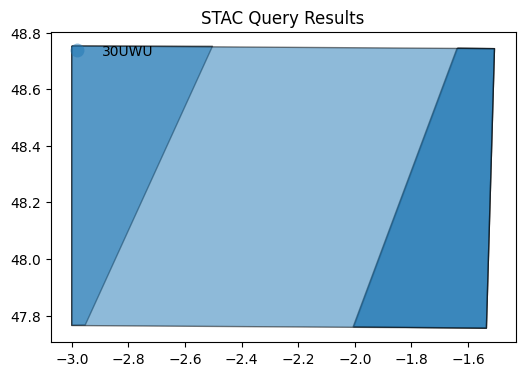

In [13]:
# région Bretagne
bretagne_box = (-4.9320997084195675, 47.169314469150706, -1.0886774891100912, 48.95925757175734)
datatime = "2023-03-01/2023-04-30" 
filters = {
    "eo:cloud_cover":{"lt": 30}, 
    # s2:nodata_pixel_percentage
    "mgrs:grid_square": {"eq": "WU"} #XU, VU, WU
}
stac_json, items = get_search_json(datatime, bretagne_box, filters)
if items:
    gdf = get_gdf(stac_json)
    plot_bounds(gdf)
    plot_bounds_map(gdf, bretagne_box)

In [14]:
gdf[['s2:product_uri', 'datetime', 'granule', 'eo:cloud_cover', 's2:vegetation_percentage', 's2:nodata_pixel_percentage']]

,s2:product_uri,datetime,granule,eo:cloud_cover,s2:vegetation_percentage,s2:nodata_pixel_percentage
0,S2B_MSIL2A_20230419T112119_N0509_R037_T30UWU_2...,2023-04-19T11:27:46.667000Z,30UWU,27.365240,36.742929,81.660384
1,S2A_MSIL2A_20230418T105621_N0509_R094_T30UWU_2...,2023-04-18T11:07:52.594000Z,30UWU,24.219592,51.742482,79.605538
2,S2A_MSIL2A_20230408T105621_N0509_R094_T30UWU_2...,2023-04-08T11:07:53.604000Z,30UWU,27.793172,52.620518,79.428285
3,S2A_MSIL2A_20230302T110951_N0509_R137_T30UWU_2...,2023-03-02T11:17:47.222000Z,30UWU,19.136761,52.589297,0.000000


Found: 2 datasets


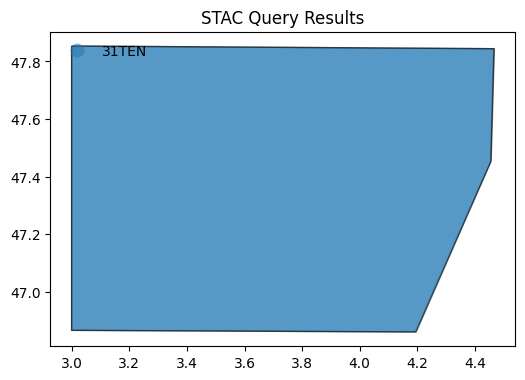

In [7]:
bbox = get_bbox(region_Bourg_bbox)  # région Bourgogne-Franche-Comté
datatime = "2023-03-15/2023-04-30"
filters = {
    "eo:cloud_cover":{"lt": 30}, 
    # s2:nodata_pixel_percentage
    "mgrs:grid_square": {"eq": "EN"} #GN
}
stac_json, items = get_search_json(datatime, bbox, filters)
if items:
    gdf = get_gdf(stac_json)
    plot_bounds(gdf)
    plot_bounds_map(gdf, bbox)

In [8]:
gdf[['s2:product_uri', 'datetime', 'granule', 'eo:cloud_cover', 's2:vegetation_percentage', 's2:nodata_pixel_percentage']]

,s2:product_uri,datetime,granule,eo:cloud_cover,s2:vegetation_percentage,s2:nodata_pixel_percentage
0,S2B_MSIL2A_20230420T104619_N0509_R051_T31TEN_2...,2023-04-20T10:57:54.708000Z,31TEN,3.626246,87.183756,5.167395
1,S2A_MSIL2A_20230405T105031_N0509_R051_T31TEN_2...,2023-04-05T10:57:52.471000Z,31TEN,1.650424,86.860758,5.095995


In [10]:
items[0].id  # id to download

'S2B_31TEN_20230420_0_L2A'

In [16]:
items[3].id

'S2A_30UWU_20230302_0_L2A'

In [21]:
items[-1]

<Item id=S2A_30UWU_20230302_0_L2A>